# Assignment 2: Voting Visualized

## Background


* Are you curious to know what the political leanings of the people of Switzerland are?
* Do you wake up in a cold sweat, wondering which party won the last cantonal parliament election in Vaud?
* Are you looking to learn all sorts of visualizations, including maps, in Python?
If your answer to any of the above is yes, this assignment is just right for you. Otherwise, it's still an assignment, so we're terribly sorry.
The chief aim of this assignment is to familiarize you with visualizations in Python, particularly maps, and also to give you some insight into how visualizations are to be interpreted. The data we will use is the data on Swiss cantonal parliament elections from 2007 to 2018, which contains, for each cantonal election in this time period, the voting percentages for each party and canton.
For the visualization part, install [Folium](Folium) (_Hint: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!_). Folium's README comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find one TopoJSON file, containing the geo-coordinates of the cantonal borders of Switzerland.
One last, general reminder: back up any hypotheses and claims with data, since this is an important aspect of the course.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# import pandas_profiling
import folium
from os.path import join
import branca.colormap as cm

from IPython.display import display

# do not use %pylab, that inserts packages into the namespace
%matplotlib inline
import matplotlib.pyplot as plt

import json
from IPython.display import IFrame
from folium.plugins import TimeSliderChoropleth
from branca.utilities import split_six
from IPython.display import display, HTML
import requests
from bs4 import BeautifulSoup

def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()


def group_and_count(df, groupby_column, with_pct=False, with_avg=False):
    result = df.groupby(groupby_column).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'})
    if with_pct:
        result['count_pct'] = result['count'] / result['count'].sum()
    if with_avg:
        result['count_avg'] = result['count'].mean()
    return result

In [2]:
data_folder = 'D:/python_workspace/school/AppliedDataAnalysis/ADA2018-Homework/homework-2-gjems_rahm_vold_ada_hw2/02 - Visualisation/data'

## Task 1: Cartography and census
__A)__ Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.
__B)__ Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?
__C)__ The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the average of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.
Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?
<img src="plaw_crop.png" style="width: 600px;">
The figure is extracted from [this paper](https://arxiv.org/pdf/cond-mat/0412004.pdf) that contains more information about this family of distributions.

__A)__ Display a Swiss map that has cantonal borders as well as the national borders. We provide a TopoJSON `data/ch-cantons.topojson.json` that contains the borders of the cantons.

In [3]:
with open(data_folder + '/ch-cantons.topojson.json', 'r') as f:
    ch_cantons = json.load(f)

ch_cantons.keys()

dict_keys(['type', 'transform', 'objects', 'arcs'])

In [4]:
topo_json_data = open(data_folder + '/ch-cantons.topojson.json', 'r')

In [5]:
center_coord = {'lon': 46.8, 'lat': 8.3} # roughly the "center" of Switzerland

default_map_values = {
    "location": list(center_coord.values()),
    "zoom_start": 8, # starting zoom when displaying map
    "min_zoom": 7, # minimum available zoom for the displayed map
    "max_zoom": 11, # maximum available zoom for the displayed map
    "control_scale": 1, # adding a scale to the map
}

switzerland_map = folium.Map(**default_map_values)

folium.TopoJson(
    open(data_folder + '/ch-cantons.topojson.json', 'r'),
    'objects.cantons',
    name='topojson'
).add_to(switzerland_map)

switzerland_map

__B)__ Take the spreadsheet `data/communes_pop.xls`, collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/catalogues-banques-donnees/tableaux.assetdetail.5886191.html), containing population figures for every commune. You can use [pd.read_excel()](https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.read_excel.html) to read the file and to select specific sheets. Plot a histogram of the population counts and explain your observations. Do not use a log-scale plot for now. What does this histogram tell you about urban and rural communes in Switzerland? Are there any clear outliers on either side, and if so, which communes?

The xls file contains some header and footer lines but also redundant information for cantons and "Bezirk" that have to be removed for the further analysis as we only care for now of the municipality level. We notice that each line that is needed starts with a series of dots. These are the records that we consider for the following steps. Some changes are performed to clean the data. Names of communes are cleaned as they also contained dots and numbers.

In [6]:
population_counts = pd.read_excel(data_folder + '/communes_pop.xls', sheet_name='2017')

In [7]:
communes_counts = population_counts[population_counts.iloc[:, 0].str.startswith('...').fillna(False)].iloc[:, [0, 1]]
communes_counts.columns = ['commune', 'population']
communes_counts['commune'] = communes_counts['commune'].replace({'\.+\d+ +': ''}, regex=True)

Municipality size frequencies are shown on the following plot. We observe that small municipallities are very numerous whereas big municipalities are really rare. At first sight, the repartition seems to follow a power-law.

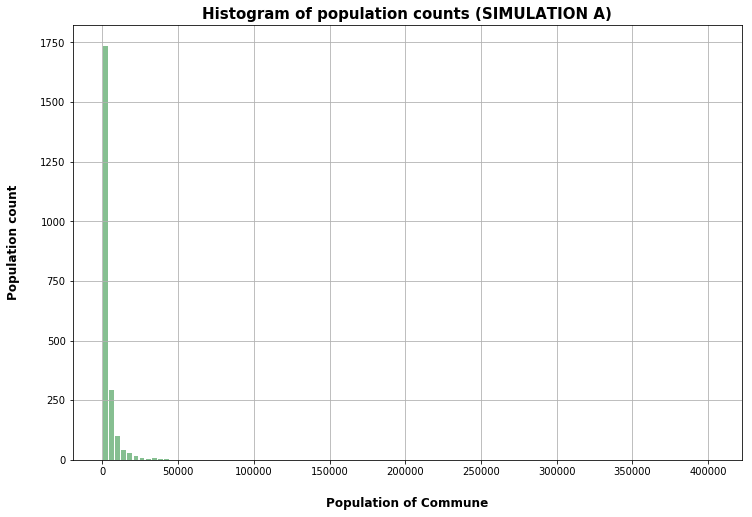

In [8]:
# Plot a histogram of population counts
ax = communes_counts['population'].plot.hist(bins=100, rwidth=0.8, grid=True, figsize=(12,8), color='#86bf91')

# Specifying title
ax.set_title("Histogram of population counts (SIMULATION A)", weight='bold', size=15)

# Set x-axis label
ax.set_xlabel("Population of Commune", labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count", labelpad=20, weight='bold', size=12);

As displayed right above, using regular bin sizes highlights the very high number of small municipalities. At the same time, the big municipalities are not visible as they are so rare. For example Zurich with a population of 400,000 is not displayed.    

The plot above shows a normal histogram of population counts produced by binning them into bins of equal size (e.g. bin width 1, in this case number of equal-width bins is 100 and the span of x-axis values go to around 400 000. Therefore, the bin width is probably around 400 000/100 = 4 000). On the linear scales used this produces a nice smooth curve. This curve reminds on a letter L. Also, this plot does not use log-scale for now. **Simulated plot a)** 
  
The following plot, however, uses the same data and is plotted using the "logarithmic binning". 

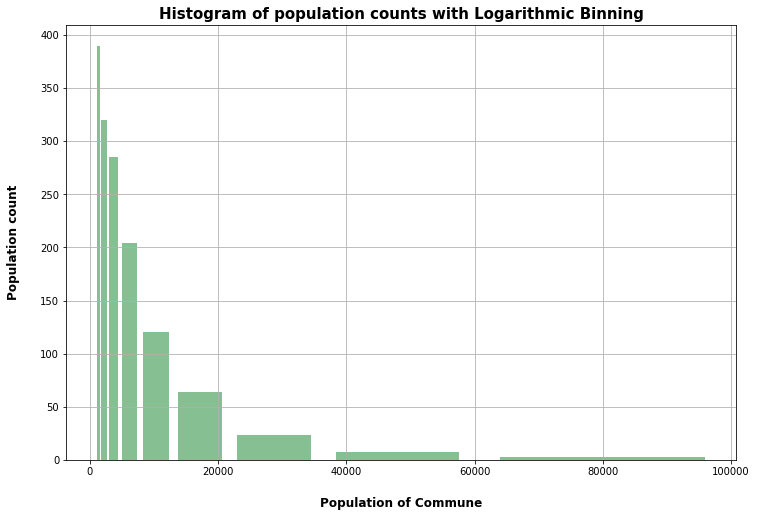

In [9]:
ax = communes_counts['population'].plot.hist(bins=np.logspace(np.log10(10**3), np.log10(10**5), 10), rwidth=0.8, grid=True, figsize=(12,8), color='#86bf91')

# Specifying title
ax.set_title("Histogram of population counts with Logarithmic Binning", weight='bold', size=15)

# Set x-axis label
ax.set_xlabel("Population of Commune", labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count", labelpad=20, weight='bold', size=12);

From this plot above we can conclude that bins are small where there is a lot of datapoints. Therefore, there are a lot of communes with a small population (*rural community*), and there is a very few communes with a huge population (*urban community*). This could be concluded from the plot that was described previously (simulation of plot a) ). The more precise numbers are shown in the following tables:

Let's have a look at the municipalities having extreme values contained in the lower 0.005 and the upper 0.995 quantile.

In [10]:
population_quantiles = communes_counts['population'].quantile([0.005, 0.995])
display(communes_counts[communes_counts['population'] < population_quantiles.values[0]].sort_values(by='population', ascending=False))
display(communes_counts[communes_counts['population'] > population_quantiles.values[1]].sort_values(by='population', ascending=False))

,commune,population
1360,Casti-Wergenstein,52
1363,Mathon,51
1796,Cerentino,51
433,Clavaleyres,49
1798,Linescio,45
1362,Lohn (GR),44
223,Rebévelier,43
319,Berken,43
219,Schelten,37
959,Kammersrohr,30


,commune,population
186,Zürich,402762
2326,Genève,198979
998,Basel,171017
1967,Lausanne,137810
382,Bern,133115
170,Winterthur,109775
551,Luzern,81592
1161,St. Gallen,75481
1746,Lugano,63932
230,Biel/Bienne,54456


The smallest municipalities are really small. The smallest is Corippo in Canton Ticino having only 14 inhabitants registered in 2017. There are 9 municipalities smaller than 50. There are 6 municipalities having over 100,000 inhabitants and the biggest is Zurich with a population of around 400,000 inhabitants. There is a much higher number of small municipalities than bigger ones.

The following table shows outliers, mostly on the rural side. All the municipalities are listed bellow:

In [11]:
communes_counts[(np.abs(communes_counts.population-communes_counts.population.mean()) > (3*communes_counts.population.std()))]

,commune,population
170,Winterthur,109775
186,Zürich,402762
230,Biel/Bienne,54456
382,Bern,133115
386,Köniz,40938
491,Thun,43568
551,Luzern,81592
998,Basel,171017
1161,St. Gallen,75481
1681,Bellinzona,42901


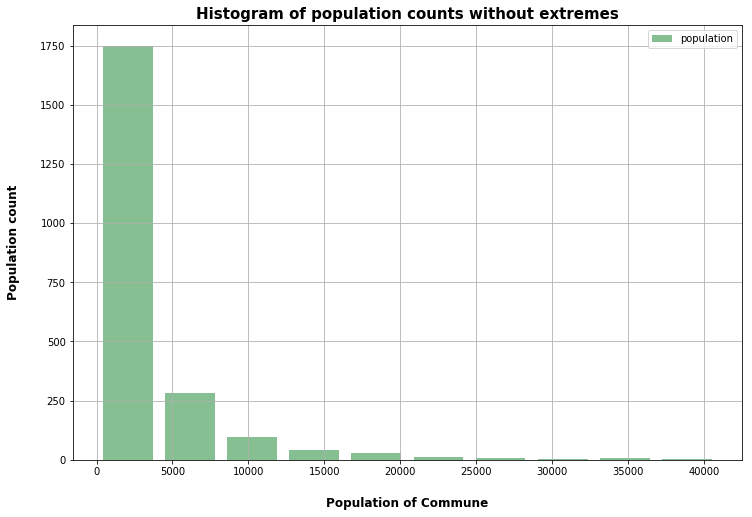

In [12]:
ax = communes_counts[communes_counts['population'] < communes_counts['population'].quantile(0.995)].plot.hist(rwidth=0.8, grid=True, figsize=(12,8), color='#86bf91')

# Specifying title
ax.set_title('Histogram of population counts without extremes', weight='bold', size=15);

# Set x-axis label
ax.set_xlabel('Population of Commune', labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count", labelpad=20, weight='bold', size=12);

Removing the low and high 0.005 quantiles, better enables to see this power-law shapped distribution. The extreme values behave even in a more extreme way than a power law.

In Switzerland we consider that cities must have at least 10,000 inhabitants to be considered as cities (see also [wikipedia](https://fr.wikipedia.org/wiki/Villes_de_Suisse)). With this definition we see that roughly half of the population is in the rural areas (not cities) and half is urban (cities). So the number of municipalities that are rural must be much greater than cities or big municipalities to make this possible. But let us check this hypothesis.

In [13]:
print('The total population of Switzerland using the dataset of year 2017 is approximately {:.1e} residents. The population distribution between rural and urban areas is shown on the following table.'.format(communes_counts['population'].sum()))
tot_rural_municipality = len(communes_counts['population'][communes_counts['population']<10000])
tot_urban_municipality = len(communes_counts['population'][communes_counts['population']>10000])
tot_rural_inhabitants = communes_counts['population'][communes_counts['population']<10000].sum()
tot_urban_inhabitants = communes_counts['population'][communes_counts['population']>10000].sum()
pd.DataFrame([[tot_rural_municipality, tot_rural_inhabitants], [tot_urban_municipality,  tot_urban_inhabitants]], columns=['municipality', 'population'], index=['rural', 'urban'])

The total population of Switzerland using the dataset of year 2017 is approximately 8.4e+06 residents. The population distribution between rural and urban areas is shown on the following table.


,municipality,population
rural,2087,4476161
urban,153,3943389


We observe that small municipalities that we consider as rural are very numerous. Municipalities having over 10,000 residents are more than 10 times less. But as they are bigger in population the total is quite similar for both rural and urban municipalities.

---

__C)__ The figure below represents 4 types of histogram. At this stage, our distribution should look like Fig.(a). A common way to represent [power-laws](https://en.wikipedia.org/wiki/Power_law) is to use a histogram using a log-log scale  -- remember: the x-axis of an histogram is segmented in bins of equal sizes and y-values are the average of each bin. As shown in Fig.(b), small bins sizes might introduce artifacts. Fig.(b) and Fig.(c) are examples of histograms with two different bin sizes. Another great way to visualize such distribution is to use a cumulative representation, as show in Fig.(d), in which the y-axis represents the number of data points with values greater than y.  
  
Create the figures (b) and (d) using the data extracted for task 1B. For Fig.(b), represent two histograms using two different bin sizes and provide a brief description of the results. What does this tell you about the relationship between the two variables, namely the frequency of each bin and the value (i.e. population in case of the communal data) for each bin?

**Answer:** To reveal the power-law form of the distribution it is better to plot the histogram on logarithmic scales. See the plot bellow:

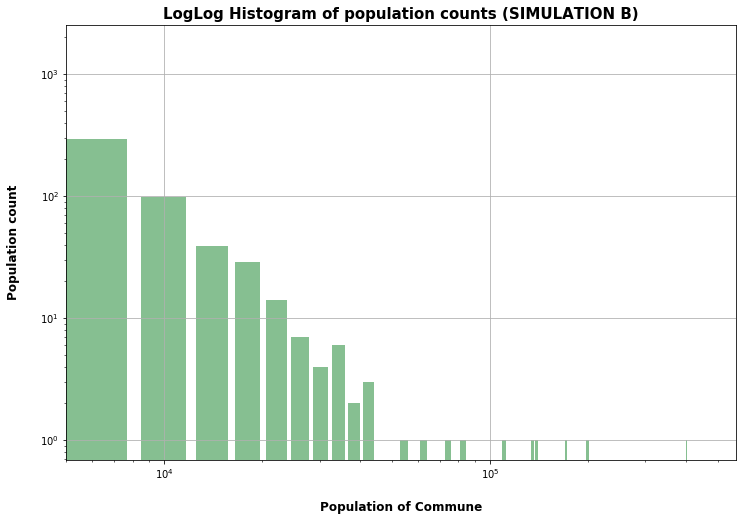

In [14]:
ax = communes_counts['population'].plot.hist(bins=100, loglog=True, rwidth =0.8, grid=True, figsize=(12,8), color='#86bf91')

# setting the limit
ax.set_xlim(5*10**3)

# Specifying title
ax.set_title("LogLog Histogram of population counts (SIMULATION B)", weight='bold', size=15)

# Set x-axis label
ax.set_xlabel("Population of Commune", labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count", labelpad=20, weight='bold', size=12);

This plot is the simulation of the **plot b)**. When we do this for the current data we see the characteristic straight-line form of the power-law distribution. However, the plot is in some respects
not a very good one. We can notice some artifacts in the tail of the plot that were mentioned in the task text. In particular the right-hand end of the distribution is noisy because of sampling errors. We can see that each bin only has a few samples in it, if any. It is nicely described in the provided paper. We cannot throw away the tail, so we are concentarting on creation of the new plot that has different bin sizes, simulation of the **plot c)**.

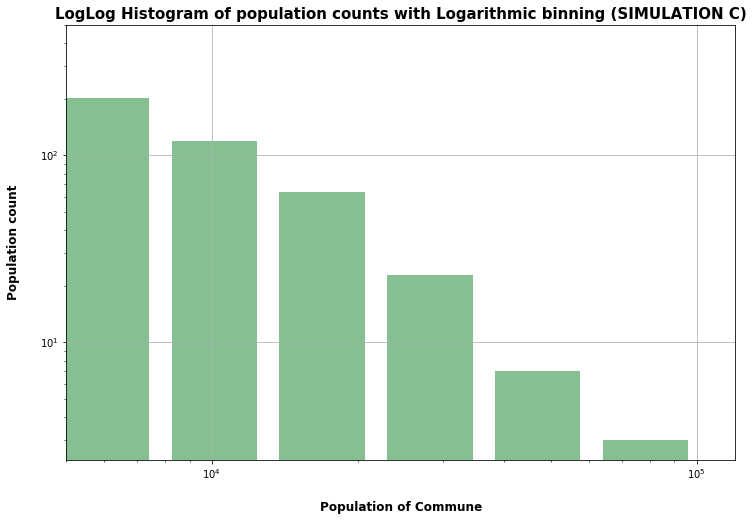

In [15]:
ax = communes_counts['population'].plot.hist(bins=np.logspace(np.log10(10**3),np.log10(10**5), 10), loglog=True, rwidth =0.8, grid=True, figsize=(12,8), color='#86bf91')

# setting the limit
ax.set_xlim(5*10**3)

# Specifying title
ax.set_title("LogLog Histogram of population counts with Logarithmic binning (SIMULATION C)", weight='bold', size=15)

# Set x-axis label
ax.set_xlabel("Population of Commune", labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count", labelpad=20, weight='bold', size=12);

We can notice that the representation of the individual bin on log scale appear equally spaces (equal width). The reason is that we are using logarithmic binning on a log-scale. As we can see, the straight-line power-law form of the histogram is now much clearer.  
  
Even with logarithmic binning there is still some noise in the tail, although it is sharply decreased. That is why we are moving to the simulation of **plot d)** which will show power-law data as a cumulative distribution.

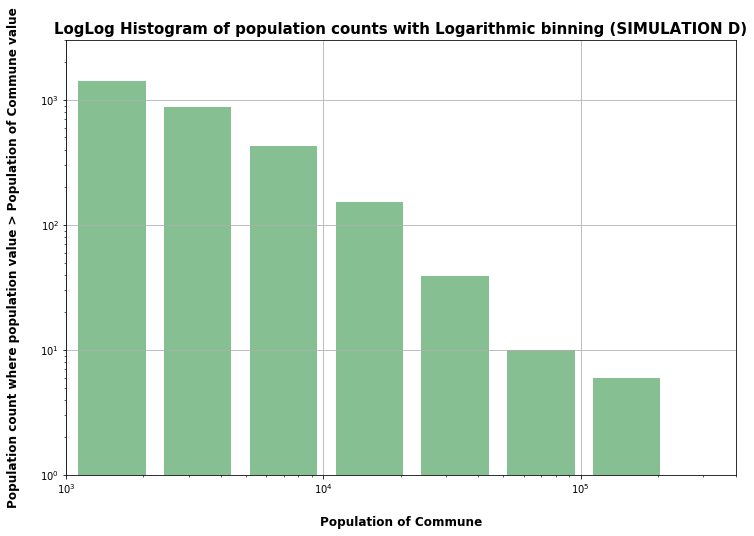

In [16]:
ax = communes_counts['population'].plot.hist(bins=np.logspace(np.log10(10**3),np.log10(10**6), 10), loglog=True, cumulative=-1, rwidth =0.8, grid=True, figsize=(12,8), color='#86bf91')

# setting the limit
ax.set_xlim((10**3, 4*10**5))
ax.set_ylim((10**(0),3000))

# Specifying title
ax.set_title("LogLog Histogram of population counts with Logarithmic binning (SIMULATION D)", weight='bold', size=15)

# Set x-axis label
ax.set_xlabel("Population of Commune", labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count where population value > Population of Commune value", labelpad=20, weight='bold', size=12);

This last plot shows power-law data as a cumulative distribution, and indeed we again see the tell-tale straight-line form of the power law, but with a shallower slope than before. In y-axis we have the number of datapoints that are greater than x. This plot is the simulation of the **plot d)**.

Can we get some more information from a cumulative plot?

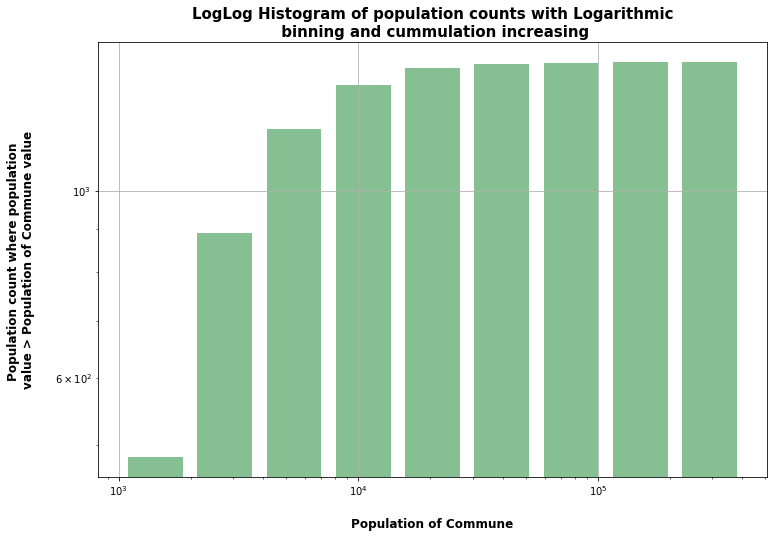

In [17]:
ax = communes_counts['population'].plot.hist(bins=np.logspace(np.log10(10**3), np.log10(4*10**5), 10), loglog=True, cumulative=True, rwidth =0.8, grid=True, figsize=(12,8), color='#86bf91')

# Specifying title
ax.set_title("LogLog Histogram of population counts with Logarithmic\n binning and cummulation increasing", weight='bold', size=15)

# Set x-axis label
ax.set_xlabel("Population of Commune", labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count where population \nvalue > Population of Commune value", labelpad=20, weight='bold', size=12);

This cumulative histogram as displayed right above highlights the fact that smaller municipalities are much more numerous than bigger ones. Municipalities with over 100,000 are very few.
We can also observe that the cumulative plot becomes more linear when using log binning as shown in the following graph. 

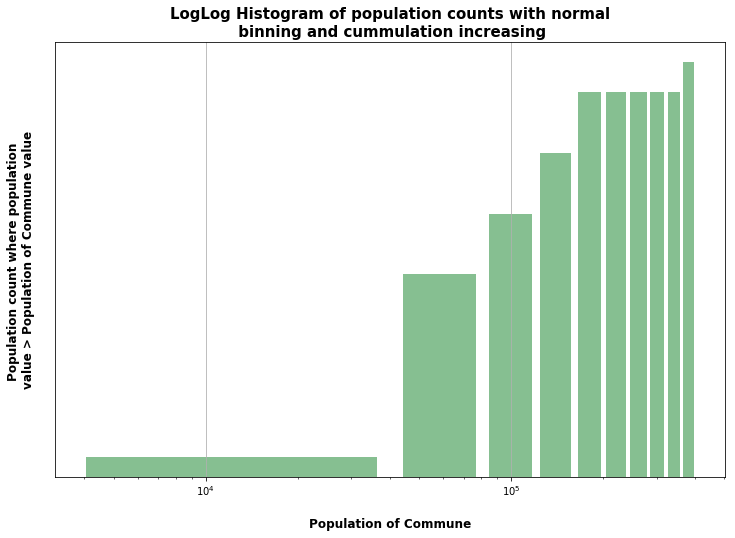

In [18]:
ax = communes_counts['population'].plot.hist(bins=10, loglog=True, cumulative=True, rwidth =0.8, grid=True, figsize=(12,8), color='#86bf91')

# Specifying title
ax.set_title("LogLog Histogram of population counts with normal\n binning and cummulation increasing", weight='bold', size=15)

# Set x-axis label
ax.set_xlabel("Population of Commune", labelpad=20, weight='bold', size=12);

# Set y-axis label
ax.set_ylabel("Population count where population \nvalue > Population of Commune value", labelpad=20, weight='bold', size=12);

Playing with the bin size allows to transform the non-linear relation of the previous graph into a more linear one. This could for example ease the modelisation as we can easily define the line relating repartition of municipalities and their population.

---

---

## Task 2: Parties visualized

We provide a spreadsheet, `data/voters.xls`, (again) collected from [admin.ch](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/force-partis.assetdetail.217195.html), which contains the percentage of voters for each party and for each canton. For the following task, we will focus on the period 2014-2018 (the first page of the spreadsheet). Please report any assumptions you make regarding outliers, missing values, etc. Notice that data is missing for two cantons, namely Appenzell Ausserrhoden and Graubünden, and your visualisations should include data for every other canton.  
  
__A)__ For the period 2014-2018 and for each canton, visualize, on the map, **the percentage of voters** in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?
  
__B)__ For the same period, now visualize **the number of residents** in each canton who voted for UDC.
  
__C)__ Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?
  
For part B, you can use the `data/national_council_elections.xslx` file ([guess where we got it from](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/participation.assetdetail.81625.html)) to have the voting-eligible population of each canton in 2015.

---

__A)__ For the period 2014-2018 and for each canton, visualize, on the map, **the percentage of voters** in that canton who voted for the party [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre). Does this party seem to be more popular in the German-speaking part, the French-speaking part, or the Italian-speaking part?

Note that Appenzell Rh. Int. still votes with their hands, so we don't have data for this Canton.

Since we will clean this dataset for other sheets as well, in order not to repeat ourselves, we are creating a method for cleaning the dataset of voters.

In [19]:
def clean_voters_dataset(voters):
    voters = voters.copy()
    # remove NaN columns
    voters.dropna(axis=1, how='all', inplace=True)  
    # remove NaN rows
    voters.dropna(axis=0, how='all', inplace=True)  

    # change column names to readable ones
    voters.rename({'Unnamed: 0':'city', 'Unnamed: 2':'year', 'Unnamed: 3':'participation', 
                   'Unnamed: 4':'PLR', 'Unnamed: 6':'PDC', 'Unnamed: 8':'PS', 'Unnamed: 10':'UDC', 
                   'Unnamed: 14':'PLS', 'Unnamed: 18':'PEV', 'Unnamed: 20':'PCS', 'Unnamed: 24':'PVL', 
                   'Unnamed: 26':'PBD', 'Unnamed: 28':'PST', 'Unnamed: 30':'PSA', 'Unnamed: 34':'PES', 
                   'Unnamed: 36':'AVF', 'Unnamed: 38':'Sol', 'Unnamed: 40':'DS', 'Unnamed: 44':'UDF', 
                   'Unnamed: 48':'Lega', 'Unnamed: 50':'MCR', 'Unnamed: 60':'others', 'Unnamed: 63':'total'}, 
                  axis='columns', inplace=True)

    # remove numbers and parenthesis from strings like 'Appenzell Rh. Ext. 3) 10)'
    def clean_city_name(city):
        return ''.join([i for i in city if not i.isdigit() and i != ")"]).strip()
    voters.city = voters.city.apply(clean_city_name)

    # setting IDs to be city codes, so we can easily use it with Topo JSON features
    voters.set_index([['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR' ,'SO' ,'BS' ,'BL' ,
                       'SH' ,'AR' ,'AI' ,'SG' ,'GR' ,'AG' ,'TG' ,'TI' ,'VD' ,'VS' ,'NE' ,'GE' ,'JU']], inplace=True)
    voters.index.name = "id"
    
    return voters

Read the data of voters:

In [20]:
voters = clean_voters_dataset(pd.read_excel(data_folder + '/voters.xls', sheet_name='actuel (2014-2018)', skipfooter=55, skiprows=5, encoding='utf-8'))
display(voters[:5])

,city,year,participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,PSA,PES,AVF,Sol,DS,UDF,Lega,MCR,others,total
id,,,,,,,,,,,,,,,,,,,,,
ZH,Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,NaN,4.271767,NaN,...,NaN,7.218776,2.977664,NaN,NaN,2.662277,NaN,NaN,0.669707,100
BE,Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,6.172897,NaN,...,0.681873,10.104467,0.495841,NaN,0.179432,3.710624,NaN,NaN,0.912781,100
LU,Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,NaN,0.199143,NaN,...,NaN,6.700011,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,100
UR,Uri,2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,NaN,NaN,NaN,...,NaN,2.378061,NaN,NaN,NaN,NaN,NaN,NaN,2.428270,100
SZ,Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,NaN,0.304428,NaN,...,NaN,0.800215,NaN,NaN,NaN,NaN,NaN,NaN,1.513578,100


Now, plot the the percentage of voters for the UDC:

In [21]:
# prepare colors for the map
linear = cm.LinearColormap(
    ['white', 'purple'],
    vmin=0, vmax=40
)

def my_color_function(feature):
    try:
        voters_num = voters.loc[feature['id'], "UDC"]
        if not np.isnan(voters_num):
            return linear(voters_num)
        else:
            return '#d3d3d3'
    except KeyError:
        return '#d3d3d3'

In [22]:
m = folium.Map(**default_map_values)

folium.TopoJson(
    open(data_folder + '/ch-cantons.topojson.json', 'r', encoding='utf-8'),
    'objects.cantons',
    name='topojson',
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5',
        'fillOpacity': 0.7
    }
).add_to(m)

linear.caption = 'UDC SVP Voter percentage [%]'
linear.add_to(m)

m.save(join('plots', 'udc-svp_votes.folium.map.html'))

In [23]:
m;
IFrame(src='plots/udc-svp_votes.folium.map.html', width=1000, height=500)

Link: [UDC SVP Votes](plots/udc-svp_votes.folium.map.html)

We can see that there is a split in the country. The northern-eastern part, including the cantons who speak primarily German vote significantly higher for the UDC/SVP than the French or Italian speaking part. For Appenzell Innerrhoden and Graubünden we don't have data.

---

__B)__ For the same period, now visualize **the number of residents** in each canton who voted for UDC.  

  
For part B, you can use the `data/national_council_elections.xslx` file ([guess where we got it from](https://www.bfs.admin.ch/bfs/fr/home/statistiques/politique/elections/conseil-national/participation.assetdetail.81625.html)) to have the voting-eligible population of each canton in 2015.


In [24]:
soup = BeautifulSoup(requests.get('https://fr.wikipedia.org/wiki/Canton_(Suisse)').content, "lxml")

s = soup.find('span', {'id': 'Donn.C3.A9es_cantonales'}).parent.fetchNextSiblings()[0]

def parse_row(row):
    abr = row.find('th').contents[0][:-1]
    fields = row.findAll('td')[0]
    french_name = fields.contents[0].contents[0]
    german_name = french_name

    c = fields.find('i')
    if c is not None:
        german_name = c.contents[0]

    return abr, french_name, german_name


cantons_names = pd.DataFrame((parse_row(row) for row in s.findAll('tr')[1:]), columns=('abr', 'french_spelling', 'german_spelling'))

In [25]:
voters = pd.read_excel(data_folder + '/voters.xls', sheet_name='actuel (2014-2018)', skipfooter=55, skiprows=5)
voters.dropna(axis=1, how='all', inplace=True)  # remove NaN columns
voters.dropna(axis=0, how='all', inplace=True)  # remove NaN rows
voters.rename({'Unnamed: 0':'canton', 'Unnamed: 2':'year', 'Unnamed: 3':'participation', 'Unnamed: 4':'PLR', 'Unnamed: 6':'PDC',
       'Unnamed: 8':'PS', 'Unnamed: 10':'UDC', 'Unnamed: 14':'PLS', 'Unnamed: 18':'PEV',
       'Unnamed: 20':'PCS', 'Unnamed: 24':'PVL', 'Unnamed: 26':'PBD', 'Unnamed: 28':'PST',
       'Unnamed: 30':'PSA', 'Unnamed: 34':'PES', 'Unnamed: 36':'AVF', 'Unnamed: 38':'Sol',
       'Unnamed: 40':'DS', 'Unnamed: 44':'UDF', 'Unnamed: 48':'Lega', 'Unnamed: 50':'MCR',
       'Unnamed: 60':'others', 'Unnamed: 63':'total'}, axis='columns', inplace=True)
voters['canton'] = voters['canton'].str.strip()

# the power of manual doing stuff!

def canton_name_fix(df):
    df = df.copy()
    df.loc[df['canton'] == 'Uri 1)', 'canton'] = 'Uri'
    df.loc[df['canton'] == 'Grisons 5)', 'canton'] = 'Grisons'
    df.loc[df['canton'] == 'Appenzell Rh. Ext. 3) 10)', 'canton'] = 'Appenzell Rhodes-Extérieures'
    df.loc[df['canton'] == 'Appenzell Rh. Int. 4) 5)', 'canton'] = 'Appenzell Rhodes-Intérieures'
    
    return df

voters = canton_name_fix(voters).merge(cantons_names, left_on='canton', right_on='french_spelling', how='left')

In [26]:
national_council_elections = pd.read_excel(data_folder + '/national_council_elections.xlsx', sheet_name='2015', skiprows=8, nrows=26)
national_council_elections.columns = ['canton',  'nb_eligible_voters', 'nb_votes', 'participation']

national_council_elections.loc[national_council_elections['canton'] == 'Glaris 1)', 'canton'] = 'Glaris'
national_council_elections.loc[national_council_elections['canton'] == 'Uri 1)', 'canton'] = 'Uri'
national_council_elections.loc[national_council_elections['canton'] == 'Obwald 1)', 'canton'] = 'Obwald'
national_council_elections.loc[national_council_elections['canton'] == 'Nidwald 1)', 'canton'] = 'Nidwald'
national_council_elections.loc[national_council_elections['canton'] == 'Appenzell Rh.-Ext. 1)', 'canton'] = 'Appenzell Rhodes-Extérieures'
national_council_elections.loc[national_council_elections['canton'] == 'Appenzell Rh.-Int. 1)', 'canton'] = 'Appenzell Rhodes-Intérieures'

national_council_elections['canton'] = national_council_elections['canton'].str.strip()

cols_to_convert = national_council_elections.columns.drop('canton')
national_council_elections[cols_to_convert] = national_council_elections[cols_to_convert].apply(pd.to_numeric)

national_council_elections = national_council_elections.merge(cantons_names, left_on='canton', right_on='french_spelling', how='left').merge(voters[['canton', 'UDC']])
national_council_elections['nb_udc_votes'] = national_council_elections['UDC'].fillna(0) / 100 * national_council_elections['nb_votes']

# setting IDs to be city codes, so we can easily use it with Topo JSON features
national_council_elections.set_index([['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR' ,'SO' ,'BS' ,'BL' ,
                   'SH' ,'AR' ,'AI' ,'GR' ,'AG' ,'TG' ,'TI' ,'VD' ,'VS' ,'NE' ,'GE' ,'JU']], inplace=True)

print(max(national_council_elections["nb_udc_votes"]))
national_council_elections.head()

128750.65390795167


,canton,nb_eligible_voters,nb_votes,participation,abr,french_spelling,german_spelling,UDC,nb_udc_votes
ZH,Zurich,907623,428837,47.248362,ZH,Zurich,Zürich,30.023215,128750.653908
BE,Berne,729203,357770,49.063155,BE,Berne,Bern,26.760869,95742.362252
LU,Lucerne,271143,138096,50.931059,LU,Lucerne,Luzern,24.115646,33302.742755
UR,Uri,26414,15091,57.132581,UR,Uri,Uri,24.053191,3629.866998
SZ,Schwytz,102145,54857,53.705027,SZ,Schwytz,Schwyz,33.115090,18165.944912


In [27]:
# prepare colors for the map
linear = cm.LinearColormap(
    ['white', 'purple'],
    vmin=0, vmax=max(national_council_elections["nb_udc_votes"])
)

def my_color_function(feature):
    try:
        nb_udc_votes_num = national_council_elections.loc[feature['id'], "nb_udc_votes"]
        if not np.isnan(nb_udc_votes_num):
            return linear(nb_udc_votes_num)
        else:
            return '#d3d3d3'
    except KeyError:
        return '#d3d3d3'

In [28]:
m = folium.Map(**default_map_values)

folium.TopoJson(
    open(data_folder + '/ch-cantons.topojson.json', 'r', encoding='utf-8'),
    'objects.cantons',
    name='topojson',
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5',
        'fillOpacity': 0.7
    }
).add_to(m)

linear.caption = 'UDC/SVP votes number of residents [%]'
linear.add_to(m)

m.save(join('plots', 'nb_residents.folium.map.html'))

In [29]:
m;
IFrame(src='plots/nb_residents.folium.map.html', width=1000, height=500)

---

__C)__ Which one of the two visualizations above would be more informative in case of a national election with majority voting (i.e. when a party needs to have the largest number of citizens voting for it among all parties)? Which one is more informative for the cantonal parliament elections?

- Assuming that only the total number of votes counts towards an election the second one would be more informative for the national elections. Since cantons with large populations dominate smaller cantons.
- For the cantonal parliament elections we would chose neither one. As the plots are generated for the national level, and are thus not really comparable. The percentage of voters however gives one more insight into the election outcome of each particular canton. Therefore our answer would be the first one.
- Depending on the task however the absolute number of votes can still be valuable. For example if you want to target the region with a large number of votes. Assuming a constant convergence-rate regions with high number of voters would have the highest convergence and thus the highest impact.

## Task 3: More socialism or more nationalism?
In this section, we focus on two parties that are representative of the left and the right on the Swiss political spectrum. You will propose a way to visualize their influence over time and for each canton.  

__A)__ Take the two parties [`UDC`](https://en.wikipedia.org/wiki/Swiss_People%27s_Party) (Union démocratique du centre) and [`PS`](https://en.wikipedia.org/wiki/Social_Democratic_Party_of_Switzerland) (Parti socialiste suisse). For each canton, we define 'right lean' in a certain period as follows:  $$\frac{VoteShare_{UDC} - VoteShare_{PS}}{VoteShare_{UDC} + VoteShare_{PS}}$$   Visualize the right lean of each canton on the map. What conclusions can you draw this time? Can you observe the [röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben) ?


Read the voters data:

In [30]:
voters = clean_voters_dataset(pd.read_excel(data_folder + '/voters.xls', sheet_name='actuel (2014-2018)', skipfooter=55, skiprows=5, encoding='utf-8'))

Calculating the Right lean using the equation given:

In [31]:
# define new column (right lean) by using the given equation
voters['right_lean'] = voters.apply(lambda row: (row['UDC'] - row['PS'])/(row['UDC'] + row['PS']), axis=1)
voters.head()

,city,year,participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,PES,AVF,Sol,DS,UDF,Lega,MCR,others,total,right_lean
id,,,,,,,,,,,,,,,,,,,,,
ZH,Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,NaN,4.271767,NaN,...,7.218776,2.977664,NaN,NaN,2.662277,NaN,NaN,0.669707,100,0.207214
BE,Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,6.172897,NaN,...,10.104467,0.495841,NaN,0.179432,3.710624,NaN,NaN,0.912781,100,0.090286
LU,Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,NaN,0.199143,NaN,...,6.700011,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,100,0.341078
UR,Uri,2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,NaN,NaN,NaN,...,2.378061,NaN,NaN,NaN,NaN,NaN,NaN,2.428270,100,0.298833
SZ,Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,NaN,0.304428,NaN,...,0.800215,NaN,NaN,NaN,NaN,NaN,NaN,1.513578,100,0.438521


In [32]:
# prepare colors for the map
linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=-1, vmax=1
)

def my_color_function(feature):
    try:
        right_lean = voters[voters.right_lean.notnull()].at[feature['id'], "right_lean"]  # "ZH", "right_lean"
        return linear(right_lean)
    except KeyError:
        return '#d3d3d3'

In [33]:
m = folium.Map(**default_map_values, tiles='cartodbpositron')

folium.TopoJson(
    open(data_folder + '/ch-cantons.topojson.json', 'r', encoding='utf-8'),
    'objects.cantons',
    name='topojson',
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5',
        'fillOpacity': 0.7
    }
).add_to(m)

linear.caption = 'Right Lean of Cantons'
linear.add_to(m)

m.save(join('plots', 'RightLean.html'))

In [34]:
m;
IFrame(src='plots/RightLean.html', width=1000, height=500)

Link: [Right Lean Map](plots/RightLean.html)

Right lean, or "preserving the old order" seems to be still a bit present on the west side (French side) of the Switzerland, as well as south part (Italian part) with canton TI. On the other hand, we can see that midle and east parts of Switzerland (German part) are directed in the oposite direction, leaning more to "changing the old order into a new order". And yes, you can observe röstigraben


---

__B)__  For each party, devise a way to visualize the difference between its 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton. Propose a way to visualize this evolution of the party over time, and justify your choices. There's no single correct answer, but you must reasonably explain your choices.

In [35]:
# 2014-2018 sheet
voters_14_18 = clean_voters_dataset(pd.read_excel(data_folder + '/voters.xls', sheet_name='actuel (2014-2018)', skipfooter=55, skiprows=5, encoding='utf-8'))

# 2010-2013 sheet
voters_10_13 = clean_voters_dataset(pd.read_excel(data_folder + '/voters.xls', sheet_name='2010-2013', skipfooter=50, skiprows=5, encoding='utf-8'))

In [36]:
display(voters_14_18[:10])
display(voters_10_13[:10])

,city,year,participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,PSA,PES,AVF,Sol,DS,UDF,Lega,MCR,others,total
id,,,,,,,,,,,,,,,,,,,,,
ZH,Zurich,2015.0,32.652497,17.327820,4.878712,19.716444,30.023215,NaN,4.271767,NaN,...,NaN,7.218776,2.977664,NaN,NaN,2.662277,NaN,NaN,0.669707,100
BE,Berne,2018.0,30.516313,11.717910,0.671415,22.328775,26.760869,NaN,6.172897,NaN,...,0.681873,10.104467,0.495841,NaN,0.179432,3.710624,NaN,NaN,0.912781,100
LU,Lucerne,2015.0,38.741267,21.039516,30.862513,11.848915,24.115646,NaN,0.199143,NaN,...,NaN,6.700011,NaN,NaN,NaN,NaN,NaN,NaN,0.036129,100
UR,Uri,2016.0,61.989056,26.856698,31.298814,12.984966,24.053191,NaN,NaN,NaN,...,NaN,2.378061,NaN,NaN,NaN,NaN,NaN,NaN,2.428270,100
SZ,Schwytz,2016.0,37.747088,21.628996,27.167707,12.925363,33.115090,NaN,0.304428,NaN,...,NaN,0.800215,NaN,NaN,NaN,NaN,NaN,NaN,1.513578,100
OW,Obwald,2018.0,53.793314,17.174703,29.803630,15.090867,24.532303,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.398497,100
NW,Nidwald,2018.0,54.921606,28.012430,26.750081,4.470053,25.916631,NaN,NaN,NaN,...,NaN,13.404058,NaN,NaN,NaN,NaN,NaN,NaN,1.446747,100
GL,Glaris,2018.0,29.489675,18.392812,9.400847,12.750408,25.275361,NaN,NaN,NaN,...,NaN,12.351048,NaN,NaN,NaN,NaN,NaN,NaN,1.803643,100
ZG,Zoug,2014.0,42.939437,22.147887,26.783136,9.250912,23.631802,NaN,NaN,NaN,...,NaN,11.631984,NaN,NaN,NaN,NaN,NaN,NaN,1.579922,100


,city,year,participation,PLR,PDC,PS,UDC,PLS,PEV,PCS,...,AVF,Sol,Unnamed: 39,DS,UDF,Lega,MCR,others,Unnamed: 61,total
id,,,,,,,,,,,,,,,,,,,,,
ZH,Zurich,2011.0,38.2347,12.934426,4.862598,19.317182,29.635552,NaN,3.778014,NaN,...,1.627417,NaN,NaN,0.405206,2.571601,NaN,NaN,0.567131,NaN,100
BE,Berne,2010.0,32.3464,10.335474,1.256537,18.852832,26.621577,NaN,5.898273,NaN,...,NaN,NaN,NaN,0.414800,4.403570,NaN,NaN,0.977237,NaN,100
LU,Lucerne,2011.0,43.469,18.864849,31.298184,10.964228,22.126508,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.511289,NaN,100
UR,Uri,2012.0,49.1591,20.281885,36.611083,12.085318,24.629866,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.499166,NaN,100
SZ,Schwytz,2012.0,45.114,22.818461,29.083853,12.381160,34.004523,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.492877,NaN,100
OW,Obwald,2010.0,52.0939,17.916261,33.807091,10.921757,21.122156,NaN,NaN,15.468807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.763928,NaN,100
NW,Nidwald,2010.0,52.9485,27.823982,31.135335,2.090228,26.614033,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.403217,NaN,100
GL,Glaris,2010.0,32.0643,20.289574,10.655142,13.920524,26.328971,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.324437,NaN,NaN,NaN,NaN,100
ZG,Zoug,2010.0,43.562,23.153618,26.516420,10.264115,22.725281,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.995661,NaN,100


The following code will describe two approaches to visualize a differece between 2014-2018 vote share (i.e. percentage) and its 2010-2013 vote share for each canton separately for each political party.
1. The first way that is used is using a **time-slider map**. Time-slider will have two states, first in 2010 representing the first dataset values (from 2010-2013 excel sheet), second in 2014 representing the second dataset values (from 2014-2018 excel sheet). Color that is used is the same, just the shade differes depending on the percentage of votes.
2. The second way of visualization is ploting a **map of difference** between these two time periods. For example, if the canton has the red color then it means that the number of votes for that party decreased more than 1% (<-1%) in 2018. On the other hand, if the canton is pained in green then it means that the number of votes increased more than 1% (>+1%) in comparison to the 2010-2013 period. Gray color is used for the values that are missing or cannot be compared since one of them is missing.

#### Time-Slider Map

In [37]:
# prepare colors for the map
linear = cm.LinearColormap(
        ['#008080', 'white'],
        vmin=0, vmax=42
    )

def my_color_function(voters, party, canton):
    try:
        if np.isnan(voters.at[canton, party]):
            return '#d3d3d3'
        return linear(voters.at[canton, party])
    except KeyError:
        return '#d3d3d3' 
    
def create_styledata_for_party(party):    
    styledata = {}
    n_periods = 2  # 2010-2013 and 2014-2018

    datetime_index = pd.date_range('2009', periods=n_periods, freq='4Y', closed='left')
    dt_index_epochs = datetime_index.astype(int) // 10**9 + 10**5
    dt_index = dt_index_epochs.astype('U10')

    for canton in voters_10_13.index:
        df = pd.DataFrame(
            {'color': [ my_color_function(voters_14_18, party, canton), 
                        my_color_function(voters_10_13, party, canton)],
             'opacity': [0.7, 0.7]},
            index=list(dt_index)
        )
        styledata[canton] = df.to_dict('index')
    
    return styledata

Conversion TopoJSON -> GeoJSON done using: http://jeffpaine.github.io/geojson-topojson/

In [38]:
def timeslider_for_party(party):
    m2 = folium.Map(**default_map_values, tiles='cartodbpositron')
    
    g1 = TimeSliderChoropleth(
        json.load(open(data_folder + '/ch-cantons.geojson.json', 'r', encoding='utf-8')),
        name='UDC',
        styledict=create_styledata_for_party(party),
    ).add_to(m2)

    m2.save(join('plots', f'TimeSlider-{party}.html'))

    return m2

In [40]:
# check that you allow d3js...
timeslider_for_party("UDC");
IFrame(src='plots/TimeSlider-UDC.html', width=1000, height=500)

German part seems to become few shades darker. That means that they increased the percentage of votes for UDC during 2014-2018. Canton JU also seems that they have increased the percentage of voting for the UDC.

Link: [TimeSlider UDC](plots/TimeSlider-UDC.html)

In [41]:
timeslider_for_party("PS");
IFrame(src='plots/TimeSlider-PS.html', width=1000, height=500)

Link: [TimeSlider PS](plots/TimeSlider-PS.html)

For PS party we can notice that on the French speaking part (VD, NE,) becomes a bit lighter shade. That means that percentage of votes for the party decreased in 2024-2028. On the other hand, canton BE becomes darker therefore the percentage of votes for PS increases. Canton AG also becomes a bit darker.

To be able to see the change, you would first really need to be concentrated on the map, but you can see it :)
Since the difference can be hardly noticable, we created another way of visualizing this difference of votes that will be shown below.

For other political parties, we generated HTML files that can be found using the following links:

In [42]:
for party in voters_14_18.columns[3:-1]:
    timeslider_for_party(party)

Timesliders (choose the party):
- [TimeSlider AVF](plots/TimeSlider-AVF.html)
- [TimeSlider DS](plots/TimeSlider-DS.html)
- [TimeSlider Lega](plots/TimeSlider-Lega.html)
- [TimeSlider MCR](plots/TimeSlider-MCR.html)
- [TimeSlider others](plots/TimeSlider-others.html)
- [TimeSlider PBD](plots/TimeSlider-PBD.html)
- [TimeSlider PCS](plots/TimeSlider-PCS.html)
- [TimeSlider PDC](plots/TimeSlider-PDC.html)
- [TimeSlider PES](plots/TimeSlider-PES.html)
- [TimeSlider PEV](plots/TimeSlider-PEV.html)
- [TimeSlider PLR](plots/TimeSlider-PLR.html)
- [TimeSlider PLS](plots/TimeSlider-PLS.html)
- [TimeSlider PS](plots/TimeSlider-PS.html)
- [TimeSlider PSA](plots/TimeSlider-PSA.html)
- [TimeSlider PST](plots/TimeSlider-PST.html)
- [TimeSlider PVL](plots/TimeSlider-PVL.html)
- [TimeSlider Sol](plots/TimeSlider-Sol.html)
- [TimeSlider UDC](plots/TimeSlider-UDC.html)
- [TimeSlider UDF](plots/TimeSlider-UDF.html)

#### Difference Map

In [43]:
# prepare colors for the map
linear = cm.LinearColormap(
    ['red', 'yellow', 'green'],
    vmin=-1, vmax=1    # just to see direction of change
)

def my_color_function2(feature, party):

    def difference():
        return voters_14_18[party].sub(voters_10_13[party], fill_value=0)
    diff_val = difference()[feature['id']]

    try:
        if not np.isnan(diff_val):
            return linear(diff_val)
        else:
            return '#d3d3d3'
    except KeyError:
        return '#d3d3d3'

In [44]:
def difference_for_party(party):
    m = folium.Map(**default_map_values, tiles='cartodbpositron')

    folium.TopoJson(
        open(data_folder + '/ch-cantons.topojson.json', 'r', encoding='utf-8'),
        'objects.cantons',
        name='topojson',
        style_function=lambda feature: {
            'fillColor': my_color_function2(feature, party),
            'color': 'black',
            'weight': 2,
            'dashArray': '5, 5',
            'fillOpacity': 0.7
        }
    ).add_to(m)

    linear.caption = 'Difference in voting (-1 = decreased; +1 = increased)'
    linear.add_to(m)

    m.save(join('plots', f'Difference-{party}.html'))

    return m

In [45]:
difference_for_party("UDC");
IFrame(src='plots/Difference-UDC.html', width=1000, height=500)

Link: [Difference UDC](plots/Difference-UDC.html)

On this kind of map we can maybe say more easily whether the percentage of votes increased or decreased lately. In canton VD the percentage of votes for UDC decreased. In canton BE it stayed almost the same, and same for the canton AG. For canton GR we dont have data. Cantons on the east seem to increased their percentage of voting for UDC.
In short, it seems that votes for democracy decreased on the west and increased on the east of Switzerland.

In [46]:
difference_for_party("PS");
IFrame(src='plots/Difference-PS.html', width=1000, height=500)

The west side of Switzerland seems to decreased the percentage for voting for the PS, exept canton GE where they seems to increase their previous percentage. Also, the middle part of Switzerland seems to increase the percentage of votes for PS in comparison to previous years. The east of Switzerland seems to stay at the same percentage as it was in previous years.
In short, it seems that votes for socializm decreased in west, increased in middle and north and stayed the same on the east side of Switzerland.

For other political parties, we generated HTML files that can be found using the following links:

Link: [Difference UDC](plots/Difference-PS.html)

In [47]:
for party in voters_14_18.columns[3:-1]:
    difference_for_party(party)

Differences (choose the party):
- [Difference AVF](plots/Difference-AVF.html)
- [Difference DS](plots/Difference-DS.html)
- [Difference Lega](plots/Difference-Lega.html)
- [Difference MCR](plots/Difference-MCR.html)
- [Difference others](plots/Difference-others.html)
- [Difference PBD](plots/Difference-PBD.html)
- [Difference PCS](plots/Difference-PCS.html)
- [Difference PDC](plots/Difference-PDC.html)
- [Difference PES](plots/Difference-PES.html)
- [Difference PEV](plots/Difference-PEV.html)
- [Difference PLR](plots/Difference-PLR.html)
- [Difference PLS](plots/Difference-PLS.html)
- [Difference PS](plots/Difference-PS.html)
- [Difference PSA](plots/Difference-PSA.html)
- [Difference PST](plots/Difference-PST.html)
- [Difference PVL](plots/Difference-PVL.html)
- [Difference Sol](plots/Difference-Sol.html)
- [Difference UDC](plots/Difference-UDC.html)
- [Difference UDF](plots/Difference-UDF.html)